symmetry_dict=dict()
blue_dict=dict()
green_dict=dict()
red_dict=dict()
border_dict=dict()

In [41]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [42]:
# Set some parameters
im_width = 128
im_height = 128
img_channels=3

In [43]:
import os
filelist=os.listdir("/home/seo/ISIC DATA")
meta=[file for file in filelist if not file.endswith(".jpeg") and not file.endswith(".png") and file.startswith("ISIC")]
pics=[file for file in filelist if (file.endswith(".jpeg") or file.endswith(".png")) and file.startswith("ISIC")]
masklist=os.listdir("/home/seo/Masks")
masks=[file for file in masklist if file.endswith(".png") and file.startswith("ISIC")]
mask2=[file.split('_segmentation')[0] for file in masklist if file.endswith(".png") and file.startswith("ISIC")]
train_pics=[file for file in pics if file.split('.jpeg')[0] in mask2]
test_pics=[file for file in pics if file.split('.jpeg')[0] not in mask2]

from tqdm import tqdm_notebook
images = np.zeros((len(train_pics), im_height, im_width, img_channels), dtype=np.uint8)
labels = np.zeros((len(train_pics), im_height, im_width, 1), dtype=np.bool)
for n, id_ in tqdm_notebook(enumerate(train_pics), total=len(train_pics)):
    img = imread("/home/seo/ISIC DATA/"+str(id_))[:,:,:img_channels]
    img = resize(img, (im_height, im_width), mode='constant', preserve_range=True)
    images[n] = img
    mask = np.zeros((im_height, im_width, 1), dtype=np.bool)
    for mask_file in next(os.walk("/home/seo/Masks"))[2]:
        mask_ = imread("/home/seo/Masks/"+id_.split('.')[0]+'_segmentation.png')
        mask_ = np.expand_dims(resize(mask_, (im_height, im_width), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    labels[n] = mask

X_train = images
Y_train = labels


In [44]:
def split_into_rgb_channels(image):
    """Split the target image into its red, green and blue channels.image - a numpy array of shape (rows, columns, 3).
    output - three numpy arrays of shape (rows, columns) and dtype same as
    image, containing the corresponding channels.
    """
    red = image[:,:,2]
    green = image[:,:,1]
    blue = image[:,:,0]
    return red, green, blue

In [45]:
def rotate_bound(image, angle,cX,cY):
    # grab the dimensions of the image
    (h, w) = image.shape[:2] 
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


In [46]:
def mse(imageA, imageB,contour_size):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(contour_size)
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [47]:
def get_mag_ang(img):

    """
    Gets image gradient (magnitude) and orientation (angle)

    Args:
        img

    Returns:
        Gradient, orientation
    """

    img = np.sqrt(img)

    gx = cv2.Sobel(np.float32(img), cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(np.float32(img), cv2.CV_32F, 0, 1)

    mag, ang = cv2.cartToPolar(gx, gy)

    return mag, ang, gx, gy 

In [48]:
def choose_img(name):
    img = load_img(name, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X = x_img/255.0
    return X

In [49]:
images = np.zeros((len(pics),im_height, im_width, 1), dtype=np.float32)

In [50]:
name="/home/seo/ISIC DATA/"+pics[i]
label=pics[i].split('.')[0]

In [51]:
orig_img=cv2.imread(name, cv2.IMREAD_COLOR)[...,::-1]
img=orig_img

#normalize image

norm_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

img=norm_image

#split image into RGB channels

r,g,b=split_into_rgb_channels(img)

#reduce noise
# Do some denoising on blue channel because that usually gives best contrast
gaussian = cv2.GaussianBlur(b,(3,3),0)

x_img = img_to_array(orig_img)
x_img=resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)


In [52]:
import numpy as np

In [53]:
from numpy import array, newaxis, expand_dims

In [54]:
#img = load_img(name, grayscale=False)
x_img = img_to_array(img)
x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
x_img=x_img/255.0
x_img2=x_img[newaxis,:,:,:]
x_img2.ndim

4

In [55]:
#imshow(x_img.squeeze())

In [56]:
resized = cv2.resize(orig_img,(128,128))
#imshow(resized)

In [57]:
#imshow(orig_img)

In [58]:
import pickle
#model=pickle.load(open('model.pickle',"rb"))
#model=pickle.load(open('model_fitted.pickle',"rb"))

In [59]:
pred=model.predict(x_img2)
preds_t = (pred > 0.5).astype(np.uint8)

In [60]:
pred.squeeze()

array([[0.01375103, 0.01037434, 0.00592881, ..., 0.01410344, 0.01751259,
        0.03598997],
       [0.01311669, 0.00900111, 0.00412554, ..., 0.00850743, 0.0130789 ,
        0.01932809],
       [0.00460854, 0.00486138, 0.00265124, ..., 0.00504616, 0.0075143 ,
        0.01398361],
       ...,
       [0.00320524, 0.00155053, 0.00115302, ..., 0.00173798, 0.00172445,
        0.00402164],
       [0.00283173, 0.00155604, 0.00115457, ..., 0.00112903, 0.00131705,
        0.00414976],
       [0.01323196, 0.0051524 , 0.00512522, ..., 0.00345805, 0.00588304,
        0.0062525 ]], dtype=float32)

In [61]:
orig_mask=preds_t.squeeze()

In [62]:
import scipy.ndimage as ndimage

In [63]:
dilated=ndimage.binary_dilation(orig_mask,structure=np.ones((5,5))).astype(orig_mask.dtype)
eroded= ndimage.binary_erosion(dilated).astype(orig_mask.dtype)
mask=eroded

In [64]:
#plt.subplot(2,2,1),imshow(dilated)
#plt.subplot(2,2,2),imshow(eroded)

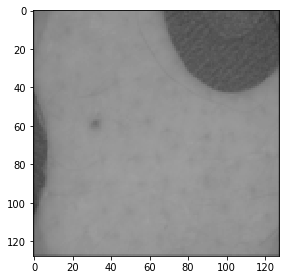

In [65]:
x_img3=x_img2.squeeze()
#imshow(x_img3)

In [66]:
import cv2
dst = cv2.bitwise_and(x_img3, x_img3, mask=mask)

In [67]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [68]:
import sys
try:
    cnt=contours[0]
    M = cv2.moments(cnt)
except:
    sys.exit(0)

SystemExit: 0

In [ ]:
(a,b),(MA,ma),angle = cv2.fitEllipse(cnt)
a=int(a)
b=int(b)
contourSize = cv2.contourArea(cnt)

In [ ]:
def rotate_bound(image, angle,cX,cY):
    # grab the dimensions of the image
    (h, w) = image.shape[:2] 
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [ ]:
rotated_roi=rotate_bound(dst,angle,a,b)
#plt.imshow(rotated_roi)

In [ ]:
from mpl_toolkits.axes_grid1 import AxesGrid

imageO=rotated_roi
imageLR=np.fliplr(rotated_roi)
imageUD=np.flipud(rotated_roi)
#plt.subplot(1,2,1),plt.imshow((imageO.astype("float")-imageLR.astype("float"))**2),plt.title('LR symmetry'),plt.xticks([]),plt.yticks([])
#plt.subplot(1,2,2),plt.imshow((imageO.astype("float")-imageUD.astype("float"))**2),plt.title('UD symmetry'),plt.xticks([]),plt.yticks([])

lr=mse(rotated_roi, np.fliplr(rotated_roi),contourSize)
ud=mse(rotated_roi, np.flipud(rotated_roi),contourSize)

#symmetry_dict[label]=(lr+ud)/2


In [ ]:
colorcheck = cv2.bitwise_and(resized, resized, mask=mask)
color = ('b','g','r')
#fig=plt.figure()
zerovalues=list()
#ax=fig.add_subplot(2,1,1)
b_list=[]
g_list=[]
r_list=[]
for i,col in enumerate(color):
    histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
    #ax.plot(histr,color = col)
    zerovalues.append(histr[0])
    histr=histr[1:]
    #plt.xlim([0,255])
    #ax.set_yscale('log')
    if col=='b':
        blue_dict[label]=histr.std()
    if col=='g':
        green_dict[label]=histr.std()
    if col=='r':
        red_dict[label]=histr.std()
#plt.title("color distribution")

In [ ]:
#imshow(colorcheck),plt.title('Result after applying mask')

In [ ]:
H,W = resized.shape[:2]
h=20; w=20
tots_gradient=[]
for point in cnt[:,0]:
    x=point[0]
    y=point[1]
    #print(x,y)
    y1=y-h; y2=y+h
    x1=x-w; x2=x+w
    if y1<0:
        y1=0
    if y2>H:
        y2=H
    if x1<0:
        x1=0
    if x2>W:
        x2=W
    #print(x1,y1,x2,y2)
    crop_img = orig_img[:,:,0][y1:y2, x1:x2].copy()
    mag,ang,gx,gy=get_mag_ang(crop_img)
    tots_gradient.append(mag.mean())
border_dict[label]=np.mean(tots_gradient)